# 6.819 / 6.869 Pset 6 

Welcome to Pset 6! The aim of this PSET is to study different issues that appear when deploying models for real applications. These issues lead to a wide range of societal and ethical issues, some of which this PSET will try to briefly illustrate. 

## Logistics
Read all the contents of this cell carefully. 

**Submissions are due by Thursday 04/07/2022 at 11:59PM**

To speed up the execution of the experiments we recommend using GPU acceleration. If you run this in Google Colab, simply do:

Runtime > Change Runtime type > Hardware accelerator > GPU.

Training a single model with the default parameters for 40 epochs will take less than 15 minutes using GPU in Google Colab (which should be available to you for free) or 3.5 hours using a CPU. You should at least train one model for Q1), but the rest of the PSET can be completed either with your model or a model provided by the instructors.

If you get the message: "Notebook requires high RAM", press OK and ignore it.


# **Q0)** Set-up the environment and download resources



If you want to store data and models in your drive, set the following variable use_gdrive to True, and possibly modify *data_dir* to point to a specific folder. This will allow you to avoid retraining models if your notebook crashes. If set to True, it will ask for permission for the Colab to access your Google Drive.

In [111]:
use_gdrive = False

In [112]:
import os
from tqdm import tqdm

if use_gdrive:
  from google.colab import drive
  drive.mount('/content/drive')

  data_dir = "/content/drive/MyDrive/notebooks_data/Pset6/data"
else:
  data_dir = "./data"

downloads_dir = data_dir + '/downloads'
datasets_dir = data_dir + '/datasets'
models_dir = data_dir + '/models'
pretrained_models = data_dir + '/pretrained_models'
q2c_data_dir = data_dir + '/q2c_data'

os.makedirs(downloads_dir, exist_ok=True)
os.makedirs(datasets_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(pretrained_models, exist_ok=True)
os.makedirs(q2c_data_dir, exist_ok=True)

mias_dataset_dir = datasets_dir + '/mias_dataset'
external_dataset_dir = datasets_dir + '/external_dataset'


In [113]:
# Download MIAS dataset
!wget http://6.869.csail.mit.edu/sp22/psets/pset6_serc_data/mias_dataset.zip -O {downloads_dir}/mias_dataset.zip
!wget http://6.869.csail.mit.edu/sp22/psets/pset6_serc_data/external_dataset.zip -O {downloads_dir}/external_dataset.zip
!wget http://6.869.csail.mit.edu/sp22/psets/pset6_serc_data/q2c_data.zip -O {downloads_dir}/q2c_data.zip

!unzip -o {downloads_dir}'/mias_dataset.zip' -d {mias_dataset_dir}
!unzip -o {downloads_dir}'/external_dataset.zip' -d {external_dataset_dir}
!unzip -o {downloads_dir}'/q2c_data.zip' -d {q2c_data_dir}

!rm -rf {downloads_dir}

# Download instructors pretrained model
!wget http://6.869.csail.mit.edu/sp22/psets/pset6_serc_data/pretreained_models/instructors_model/model.pth -O {pretrained_models}/instructors_model.pth

Streaming output truncated to the last 5000 lines.
  inflating: ./data/datasets/mias_dataset/train/normal/A_0511_1.RIGHT_MLO.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0565_1.LEFT_CC.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0565_1.LEFT_MLO.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0572_1.LEFT_MLO.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0565_1.RIGHT_MLO.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0567_1.LEFT_CC.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0609_1.RIGHT_CC.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0501_1.RIGHT_CC.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0501_1.LEFT_MLO.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0501_1.RIGHT_MLO.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0502_1.LEFT_CC.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0502_1.RIGHT_MLO.jpg  


# **Q1)** Train an image classifier (2 points)

To begin with, you will use the experience you gained in Pset 5 to train a simple image model, that learns to produce a diagnosis in the categories: *normal*, *malignant* and *benign*. Experiment with some of the following hyperparameters / techniques, by modifying the cells that follow:

*   Starting with a pretrained model
*   Data augmentation
*   Weight initialization
*   Residual connections (ResNet) and dense connections (DenseNet), compared to networks without them (VGGNet, AlexNet)
*   Number of layers, or number of layer features
*   Type of optimizer
*   Learning rate and/or schedule
*   Early stopping


For the final set of technique you choose, explain how they affect performance and (optionally), train using different hyperparameters. Your trained network should achieve a validation accuracy of at least 90%. Report the train and test Top-1 accuracy of your final network. 

Then, save the best performing model for analysis on the following questions (or you can use the instructors provided network), and report your design choices in your final document (such as ResNet-18, data augmentation by rotation, SGD optimizer, learning rate of 0.5, 10% dropout)

## Section 1: Training a Model

This code was adapted from <https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html>

You are free to delete this code entirely and start from scratch, or modify it in whatever way you choose to implement your proposed modifications.

### Dependencies

In [114]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
# You might not have tqdm, which gives you nice progress bars
!pip install tqdm
from tqdm.notebook import tqdm
import os
import copy
import pandas as pd
import PIL 
  
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

Using the GPU!


### Initialize an Empty Model

First, we need to initialize an empty model, that will input an image, and output a classification. Each model is a little different, so we'll make a helper function that takes in an architecture name, and outputs a model. This is only meant as a guideline, and you can try using different models! `torchvision.models` has other common architectures, and variations on these (like ResNet-50 and ResNet-101), so you may want to try those out.

We also add a `resume_from` argument to specify model weights to load, In case you save a model and want to use it again.

In [115]:
def initialize_model(model_name, num_classes, resume_from = None, use_pretrained = False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    # The model (nn.Module) to return
    model_ft = None
    # The input image is expected to be (input_size, input_size)
    input_size = 0
    
    # By default, all parameters will be trained (useful when you're starting from scratch)
    # Within this function you can set .requires_grad = False for various parameters, if you
    # don't want to learn them

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    else:
        raise Exception("Invalid model name!")
    
    if resume_from is not None:
        print("Loading weights from %s" % resume_from)
        model_ft.load_state_dict(torch.load(resume_from))
    
    return model_ft, input_size

### Data Loading

With the input size from the model, we can now load the dataset

In [116]:
from torchvision.transforms.functional import to_grayscale

def get_image_transforms():
    # How to transform the image when you are loading them.
    # you'll likely want to mess with the transforms on the training set.
    
    # we convert the image to a [C,H,W] tensor, then normalize it to values with a given mean/stdev. These normalization constants
    # are derived from aggregating lots of data and happen to produce better results.
    transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    return transform

def get_dataloaders(dataset_dir, input_size, batch_size, shuffle = True, transform=get_image_transforms()):
    data_transforms = {
        'train': transform,
        'val': transform,
        'test': transform
    }
    # Create training, validation and test datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(dataset_dir, x), data_transforms[x]) for x in data_transforms.keys()}
    # Create training, validation and test dataloaders
    # Never shuffle the test set
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict

### Training
Next, let's make a helper function that trains the given model

In [117]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, save_all_epochs=False, num_epochs=25):
    '''
    model: The NN to train
    dataloaders: A dictionary containing at least the keys 
                 'train','val' that maps to Pytorch data loaders for the dataset
    criterion: The Loss function
    optimizer: The algorithm to update weights 
               (Variations on gradient descent)
    num_epochs: How many epochs to train for
    save_dir: Where to save the best model weights that are found, 
              as they are found. Will save to save_dir/weights_best.pt
              Using None will not write anything to disk
    save_all_epochs: Whether to save weights for ALL epochs, not just the best
                     validation error epoch. Will save to save_dir/weights_e{#}.pt
    '''
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # torch.max outputs the maximum value, and its index
                    # Since the input is batched, we take the max along axis 1
                    # (the meaningful outputs)
                    _, preds = torch.max(outputs, 1)

                    # backprop + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train':
                train_acc_history.append(epoch_acc)
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if save_all_epochs:
                torch.save(model.state_dict(), os.path.join(save_dir, f'weights_{epoch}.pt'))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # save and load best model weights
    torch.save(best_model_wts, os.path.join(save_dir, 'weights_best_val_acc.pt'))
    torch.save(model.state_dict(), os.path.join(save_dir, 'weights_last.pt'.format(epoch)))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

### Optimizer & Loss
We need a loss function, and an optimization function to use to try to reduce that loss.

In [118]:
def make_optimizer(model, learning_rate, print_parameters=False):
    # Get all the parameters
    params_to_update = model.parameters()
    if print_parameters:
      print("Params to learn:")
      for name, param in model.named_parameters():
          if param.requires_grad == True:
              print("\t",name)

 
    optimizer = optim.Adam(params_to_update, lr=learning_rate)
    return optimizer

def get_loss():
    # Create an instance of the loss function
    criterion = nn.CrossEntropyLoss()
    return criterion

### Parameters

Here, we set up some of the various parameters that we can change to run the code. You can add change the values given here, or add new ones! This is just a template.

Our data is conveniently set up to follow the expected format of the  `ImageFolder <https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder>`__
dataset class, rather than writing our own custom dataset.

The ``model_name`` input is the name of the model you wish to use. We've provided starter code that initializes these models using provided models in TorchVision (a PyTorch library)

The code as is supports the following values: [resnet, alexnet, vgg, squeezenet, densenet]

The other inputs are as follows: ``num_classes`` is the number of
classes in the dataset, 3 here, ``batch_size`` is the batch size used for
training and may be adjusted according to the capability of your
machine, ``num_epochs`` is the number of training epochs (passes through the dataset) we want to run.




In [119]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
# You can add your own, or modify these however you wish!

##Can change this
model_name = 'resnet'

# Number of classes in the dataset, normal, benign, malignant
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Shuffle the input data?
shuffle_datasets = True

##Can change this
# Number of epochs to train for 
num_epochs = 3

##Can change this
# Learning rate
learning_rate = 0.0001

### IO
# Path to a model file to use to start weights at
resume_from = None

# Whether to use a pretrained model, trained for classification in Imagenet-1k 
pretrained = False

# Save all epochs so that you can select the model from a particular epoch
save_all_epochs = False

# Whether to use early stopping (load the model with best accuracy), or not
early_stopping = True

# Directory to save weights to
save_dir = models_dir + '/trained_model_1'
os.makedirs(save_dir, exist_ok=True)


### Tying it all together - Training

In [126]:
# Initialize the model for this run
# train model_1
model_1, input_size = initialize_model(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)
dataloaders = get_dataloaders(mias_dataset_dir, input_size, batch_size, shuffle_datasets)
criterion = get_loss()

# Move the model to the gpu if needed
model_1 = model_1.to(device)

optimizer_1 = make_optimizer(model_1, learning_rate)

# Train the model!
trained_model_1, validation_history_1, train_history_1 = train_model(model=model_1, 
                                                                     dataloaders=dataloaders, 
                                                                     criterion=criterion, 
                                                                     optimizer=optimizer_1,
                                                                     save_dir=save_dir, 
                                                                     save_all_epochs=save_all_epochs, 
                                                                     num_epochs=num_epochs)
del model_1, optimizer_1, trained_model_1

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/3
----------


  0%|          | 0/77 [00:00<?, ?it/s]

train Loss: 0.4255 Acc: 0.8628


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss: 0.3830 Acc: 0.9010

Epoch 2/3
----------


  0%|          | 0/77 [00:00<?, ?it/s]

train Loss: 0.2212 Acc: 0.9136


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss: 0.1945 Acc: 0.9208

Epoch 3/3
----------


  0%|          | 0/77 [00:00<?, ?it/s]

train Loss: 0.1411 Acc: 0.9416


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss: 0.3883 Acc: 0.8878

Training complete in 0m 32s
Best val Acc: 0.920792


### Select the model you will use for the rest of the PSET

In [127]:
# Load your final model, that we will use for the rest of the PSET.
if early_stopping:
  weights_file = save_dir + '/weights_best_val_acc.pt'
else:
  weights_file = save_dir + '/weights_last.pt'
model_yours, _ = initialize_model(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)

# Move the model to the gpu if needed
model_yours = model_yours.to(device)

# Load weights for model_yours
model_yours.load_state_dict(torch.load(weights_file))

# Load instructors model:

model_inst = torch.load(pretrained_models + '/instructors_model.pth')
model_inst = model_inst.to(device)


# set models to eval mode
model_yours = model_yours.eval()
model_inst = model_inst.eval()




## Section 2: Inference using a model

Now that we've trained a model, we would like to use it for inference on the test data. We will use a function that can compute top-k performance (i.e. whether the correct prediction is in the top-k predicted classes), but for this pset, we will keep k = 1, as there are only 3 classes.


In [128]:
def evaluate(model, dataloader, criterion, is_labelled = False, generate_labels = True, k = 5):
    # If is_labelled, we want to compute loss, top-1 accuracy and top-5 accuracy
    # If generate_labels, we want to output the actual labels
    # Set the model to evaluate mode
    model.eval()
    running_loss = 0
    running_top1_correct = 0
    running_top5_correct = 0
    predicted_labels = []
    gt_labels = []

    # Iterate over data.
    # TQDM has nice progress bars
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        tiled_labels = torch.stack([labels.data for i in range(k)], dim=1) 
        # Makes this to calculate "top 5 prediction is correct"
        # [[label1 label1 label1 label1 label1], [label2 label2 label2 label label2]]

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs = model(inputs)
            if is_labelled:
                loss = criterion(outputs, labels)

            # torch.topk outputs the maximum values, and their indices
            # Since the input is batched, we take the max along axis 1
            # (the meaningful outputs)
            _, preds = torch.topk(outputs, k=k, dim=1)
            if generate_labels:
                # We want to store these results
                nparr = preds.cpu().detach().numpy()
                predicted_labels.extend([list(nparr[i]) for i in range(len(nparr))])
                gt_labels.extend(np.array(labels.cpu()))

        if is_labelled:
            # statistics
            running_loss += loss.item() * inputs.size(0)
            # Check only the first prediction
            running_top1_correct += torch.sum(preds[:, 0] == labels.data)
            # Check all 5 predictions
            running_top5_correct += torch.sum(preds == tiled_labels)
        else:
            pass

    # Only compute loss & accuracy if we have the labels
    if is_labelled:
        epoch_loss = float(running_loss / len(dataloader.dataset))
        epoch_top1_acc = float(running_top1_correct.double() / len(dataloader.dataset))
        epoch_top5_acc = float(running_top5_correct.double() / len(dataloader.dataset))
    else:
        epoch_loss = None
        epoch_top1_acc = None
        epoch_top5_acc = None
    
    # Return everything
    return epoch_loss, epoch_top1_acc, gt_labels, predicted_labels  

In [129]:
# Get data on the validation set
# Setting this to false will be a little bit faster
generate_validation_labels = True
val_loss_yours, val_top1_yours, _, val_labels_yours = evaluate(model_yours, dataloaders['val'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 1)
# Get predictions for the test set
test_loss_yours, test_top1_yours, _, test_labels_yours = evaluate(model_yours, dataloaders['test'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 1)

val_loss_inst, val_top1_inst, _, val_labels_inst = evaluate(model_inst, dataloaders['val'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 1)
# Get predictions for the test set
test_loss_inst, test_top1_inst, _, test_labels_inst = evaluate(model_inst, dataloaders['test'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 1)

print("Your Trained model: ")
print("Val Top-1 Accuracy: {}".format(val_top1_yours))
print("Test Top-1 Accuracy: {}".format(test_top1_yours))

print("Instructors model: ")
print("Val Top-1 Accuracy: {}".format(val_top1_inst))
print("Test Top-1 Accuracy: {}".format(test_top1_inst))

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Your Trained model: 
Val Top-1 Accuracy: 0.9207920792079208
Test Top-1 Accuracy: 0.9117647058823529
Instructors model: 
Val Top-1 Accuracy: 0.9636963696369637
Test Top-1 Accuracy: 0.9477124183006537


Select either your model or the instructors model for the next questions. If your model does not achieve high accuracy (>=0.93 on the test set), you should use the instructors model (model_inst).

In [124]:
model = model_inst
# model = model_yours

# **Q2)** Accuracy isn't everything (4 points)

In the previous question, you may have achieved high accuracy, but that doesn't necessarily mean that the system is uesful for diagnosis in practice. Suppose that you model just learns nothing and outputs *normal* for every image. If 90%  of the patient images in your dataset are *normal*, the accuracy is as high as 90%! 

In this question, we will introduce some other metrics commonly used in biomedical imaging tasks. First, we define a function to get detail evaluation results on the test set:

In [125]:
# Warpper to easily evaulate a model given a model and the set of dataloaders
def get_eval_results(model, dataloaders):
    model.eval()
    true_label_list = []
    outputs_list = []
    predicted_label_list = []
    original_image_list = []

    # TQDM has nice progress bars
    for inputs, labels in tqdm(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs = model(inputs)
            true_label_list.append(labels)
            original_image_list.append(inputs)
            outputs_list.append(outputs)
            _, preds = torch.topk(outputs, k=1, dim=1)
            predicted_label_list.append(preds)
    return torch.concat(true_label_list).unsqueeze(-1).cpu().numpy(), \
           torch.concat(predicted_label_list).cpu().numpy(), \
           torch.softmax(torch.concat(outputs_list), dim=1).cpu().numpy(), \
           torch.concat(original_image_list).cpu().numpy()

## Please make sure you understand what outputs means here
y_label, y_pred, outputs, inputs =  get_eval_results(model, dataloaders)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



###**Q2 a)** Confusion matrix (1 point)

The first simple method that we will use to delve deeper into the results is the confusion matrix.


In [91]:
import seaborn as sns

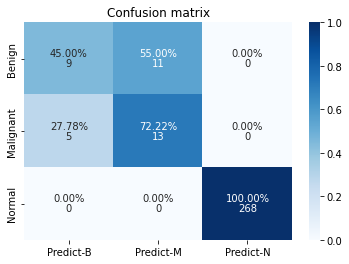

In [92]:
### Complete your code here to plot your confusion matrix 
### please plot it without using metrics packages here for better understanding 
def plot_confusion_matrix(y_label, y_pred, title2='Confusion matrix'):
    ### TODO 1
    unork = np.unique(y_label)
    cmat = np.zeros((len(unork), len(unork)))
    for i in range(len(unork)):
        for j in range(len(unork)):
           cmat[i, j] = np.sum((y_label==unork[i])&(y_pred==unork[j]))
    row_sum = cmat.sum(axis=1)
    cmat_p = pd.DataFrame((cmat / row_sum[:, np.newaxis]))
    sns.heatmap(cmat_p, cmap="Blues", annot = False, fmt='g')
    sns.heatmap(cmat_p, cmap="Blues", annot=cmat_p, annot_kws={'va':'bottom'}, fmt = '.2%', cbar=False)
    sns.heatmap(cmat_p, cmap="Blues", annot=cmat, annot_kws={'va':'top'}, fmt="g", cbar=False, xticklabels = ['Predict-B', 'Predict-M', 'Predict-N'] ).set(title = title2, yticklabels = ['Benign', 'Malignant', 'Normal'])
plot_confusion_matrix(y_label, y_pred)

###**Q2 b)** AUPRC (1 point)
***Important: Our dataset has 3 classes. In order to use some definitions in binary classification tasks, you need to create binary labels from the given class labels. Imagine a scenario where you really care about malignant cases. Please consider malignant class (label 1) to be the positive class. And both benign (label 0) and normal (label 2) classes are negative***




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


Text(0.6, 0.2, 'AUC = 0.5423')

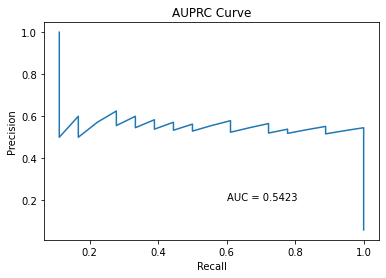

In [133]:
#from itertools import Predicate
### write your code here to plot your AUPRC curve for the model 
### please plot it without using metrics packages here for better understanding 

### use the returned values from the get_aval_results() above 
### TODO 2
thresh_range = np.linspace(0,1,10000)
truth = np.where(y_label.reshape(-1) != 1, 0, 1)
prec = []
recall = []
for i in thresh_range:
  y_pred = np.where(outputs[:,1] >= i, 1, 0)
  tpr = sum(np.where((y_pred == 1) & (truth == 1), 1, 0))
  recall.append(tpr / sum(truth))
  prec.append(tpr / sum(y_pred))
AUC = sum(np.where(np.isnan(prec),0,prec))/len(prec)

plt.plot(recall, prec)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AUPRC Curve')
plt.text(0.6,0.2,f'AUC = {AUC.round(4)}')

###**Q2 c)** Fairness Metrics (2 points)
***Important: please only use malignant class (class label 1) as positive, and both benign and normal to be negative.***

In [94]:
# fairness_vgg_1.csv fairness_vgg_2.csv which has age distribution for the malignant class of the datasets that these models were trained on
# q2c_data_dir/test: a folder with test images
# test_age.csv: a csv with test image names and its corresponding age
# fairness_vgg_1.pt and fairness_vgg_2.pt are the pretrained weights  

# create 2 empty vgg models and load pre-trained weights 
fairness_model_name = "vgg"

fairness_model_1, input_size = initialize_model(model_name = fairness_model_name, num_classes = num_classes, resume_from = None)
fairness_model_2, input_size = initialize_model(model_name = fairness_model_name, num_classes = num_classes, resume_from = None)
fairness_model_1 = fairness_model_1.to(device)
fairness_model_2 = fairness_model_2.to(device)
fairness_model_1.load_state_dict(torch.load(q2c_data_dir +'/fairness_vgg_1.pt'))
fairness_model_2.load_state_dict(torch.load(q2c_data_dir +'/fairness_vgg_2.pt'))


# prepare fairness_dataloader using ImageFolder again and please do not change shuffle=False
fairness_testset= datasets.ImageFolder(os.path.join(q2c_data_dir, 'test'), get_image_transforms())
dataloader_fair = torch.utils.data.DataLoader(fairness_testset, batch_size=32, shuffle=False)
fairness_dataloader = {'test': dataloader_fair}


fairness_test_age = pd.read_csv(q2c_data_dir+'/test_age.csv', header=None,  names=['img_name', 'age'])
age_list= []
# get an age_list which should corresponds to the evaluation results 
# This is what ImageFolder source uses. Use this to make sure age_list is ordered the same as the fairness_dataloader
for root, _, fnames in sorted(os.walk(os.path.join(q2c_data_dir, 'test'), followlinks=True)):
    for fname in sorted(fnames):
        age_list.append(fairness_test_age[fairness_test_age.loc[:, 'img_name'] == fname].loc[:, 'age'].values[0])

# Finally let's run get_eval_results on this!
y_label, y_pred_f1, outputs_f1, inputs =  get_eval_results(fairness_model_1, fairness_dataloader)
y_label, y_pred_f2, outputs_f2, inputs =  get_eval_results(fairness_model_2, fairness_dataloader)

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

# c.i)

In [28]:
### TODO now it is your turn to evaluate the model based on our instructions in the PDF
### use y_label, y_pred_f1, y_pred_f2 and age_list
### focus on malignant class which has class label 1 

### TODO 3

by_label = np.where((y_label==0) | (y_label==2), 0, 1)
by_pred_f1 = np.where((y_pred_f1==0) | (y_pred_f1==2), 0, 1)
by_pred_f2 = np.where((y_pred_f2==0) | (y_pred_f2==2), 0, 1)
good1 = 0
tot1 = 0
for i in range(len(by_label)):
  tot1+=1
  if by_pred_f1[i] == by_label[i]:
    good1+=1
print(f'Accuracy of model 1: {good1/tot1}')

good2 = 0
tot2 = 0
for i in range(len(by_label)):
  tot2+=1
  if by_pred_f2[i] == by_label[i]:
    good2+=1
print(f'Accuracy of model 2: {good2/tot2}')



Accuracy of model 1: 0.7266099635479951
Accuracy of model 1: 0.7569866342648846


# c.ii)

In [29]:
young_ind = [i for i, n in enumerate(fairness_test_age.age) if ((n>=60) & (n<70))]
old_ind = [i for i, n in enumerate(fairness_test_age.age) if n>=70]


In [31]:
tp_f1_y = 0
fn_f1_y = 0
for i in young_ind:
  tp_f1_y += ((by_label[i]==1)&(by_pred_f1[i]==by_label[i]))
  fn_f1_y += ((by_label[i]==1)&(by_pred_f1[i]!=by_label[i]))
equal_odds_y = tp_f1_y/(tp_f1_y+fn_f1_y)
tp_f1_o = 0
fn_f1_o = 0
for i in old_ind:
  tp_f1_o += ((by_label[i]==1)&(by_pred_f1[i]==by_label[i]))
  fn_f1_o += ((by_label[i]==1)&(by_pred_f1[i]!=by_label[i]))
equal_odds_o = tp_f1_o/(tp_f1_o+fn_f1_o)
print(equal_odds_y)
print(equal_odds_o)


[0.55681818]
[0.61956522]


In [32]:
tp_f2_y = 0
fn_f2_y = 0
for i in young_ind:
  tp_f2_y += ((by_label[i]==1)&(by_pred_f2[i]==by_label[i]))
  fn_f2_y += ((by_label[i]==1)&(by_pred_f2[i]!=by_label[i]))
equal_odds_y = tp_f2_y/(tp_f2_y+fn_f2_y)
tp_f2_o = 0
fn_f2_o = 0
for i in old_ind:
  tp_f2_o += ((by_label[i]==1)&(by_pred_f2[i]==by_label[i]))
  fn_f2_o += ((by_label[i]==1)&(by_pred_f2[i]!=by_label[i]))
equal_odds_o = tp_f2_o/(tp_f2_o+fn_f2_o)
print(equal_odds_y)
print(equal_odds_o)

[0.55681818]
[0.5326087]


In [33]:
fairness_train1_age = pd.read_csv(q2c_data_dir+'/fairness_vgg_1.csv', header=None,  names=['age'])
fairness_train2_age = pd.read_csv(q2c_data_dir+'/fairness_vgg_2.csv', header=None,  names=['age'])
mal_ind1 = [i for i, n in enumerate(by_pred_f1) if n==1]
mal_ind2 = [i for i, n in enumerate(by_pred_f2) if n==1]
mal_set_1 = fairness_train1_age.iloc[mal_ind1]
mal_set_2 = fairness_train2_age.iloc[mal_ind2]

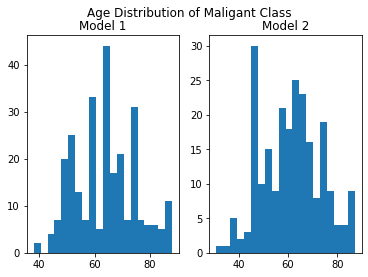

In [99]:

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Age Distribution of Maligant Class')
ax1.hist(mal_set_1.age, bins=20);
ax1.title.set_text('Model 1')
ax2.hist(mal_set_2.age, bins=20);
ax2.title.set_text('Model 2')
fig.show()

# **Q3)** Where is the model looking at? (3 points)

A common technique used to delve deeper into trained models are visualizations. As studied in the previous PSET, filter visualizations are seometimes useful to understand how the network behaves, but it is hard for non-expert users to interpret them.

## **Q3 a)** Grad-CAM

Another technique studied is CAM visualizations, which provide a simple way to interpret what regions of the image contribute to the prediction for each output target. This is a useful tool to check whether the model is picking up spuroious correlations or the predictions focus on regions of the image that are consistent with expert knowledge.

In the following code snippet, we use the following pytorch package that implements different variatinos of CAM:
https://github.com/jacobgil/pytorch-grad-cam

Run Grad-CAM (or another of the CAM visualization) on several images and classes for the different test sets. Provide some examples in your notebook and explain the differences you see between correct and incorrect classified samples.

In [35]:
!pip install grad-cam

import random
from collections import defaultdict

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


     |████████████████████████████████| 4.5 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.3.7-py3-none-any.whl size=25953 sha256=a323865eb3649d360690ed15eee80416394ab59b35fcf79be30c1798d246b833
  Stored in directory: /root/.cache/pip/wheels/30/ab/9c/53c523785edffdc6c61755cf82e0dac3342d0d36190c187894
Successfully built grad-cam


In [36]:
def plot_cams(target_dataloaders, cam_method=GradCAM, class_id='gt'):
  assert class_id in ['gt', 'pred'] or type(class_id) is int and class_id < 3
  for split in ['train', 'val', 'test']:
    target_layers = [model.layer4[-1]]
    fig, axs = plt.subplots(2, 6, figsize=(14, 7))
    fig.suptitle("Examples split {}, class {}".format(split, class_id), fontsize=16)

    split_dataset = target_dataloaders[split].dataset
    indices_per_class = defaultdict(list)
    for i, (_, c) in enumerate(split_dataset.imgs):
      indices_per_class[c].append(i)

    random.seed(1337)  
    indices = []
    for c in range(3):
      indices.extend(random.sample(indices_per_class[c], 4))

    for dataset_i, ax in zip(indices, axs.flatten()):
      input_tensor, class_idx = split_dataset[dataset_i]
      input_tensor = input_tensor[None,...].cuda()

      # Construct the CAM object once, and then re-use it on many images:
      cam = cam_method(model=model, target_layers=target_layers, use_cuda=not device == 'cpu')
      pred_class_idx = model(input_tensor).argmax()

      # We have to specify the target we want to generate
      # the Class Activation Maps for
      if class_id is int:
        target_class_id = class_id
      else:
        target_class_id = pred_class_idx if class_id == 'pred' else class_idx        
      targets = [ClassifierOutputTarget(target_class_id)]

      # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
      grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

      # In this example grayscale_cam has only one image in the batch:
      grayscale_cam = grayscale_cam[0, :]
      rgb_image = np.array(input_tensor[0].cpu())
      rgb_image = (rgb_image - rgb_image.min())/ (rgb_image.max() - rgb_image.min())
      visualization = show_cam_on_image(rgb_image.transpose((1,2,0)), grayscale_cam, use_rgb=True)
      
      ax.set_title('True : %s\n Predicted: %s' %(split_dataset.classes[class_idx], split_dataset.classes[pred_class_idx]))
      ax.imshow(visualization)


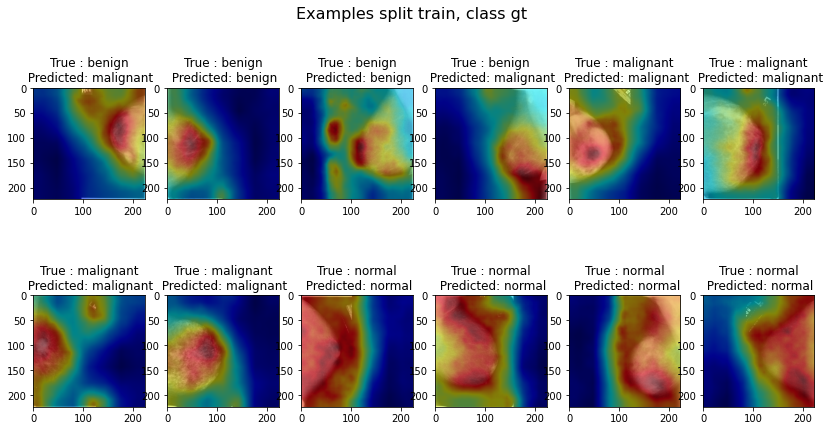

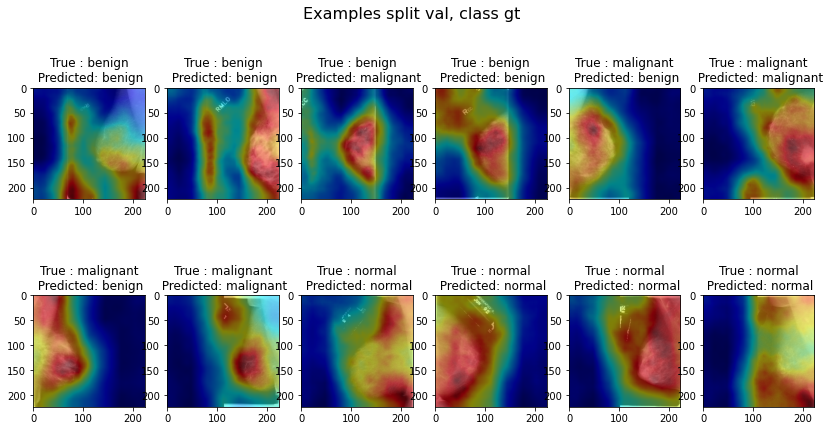

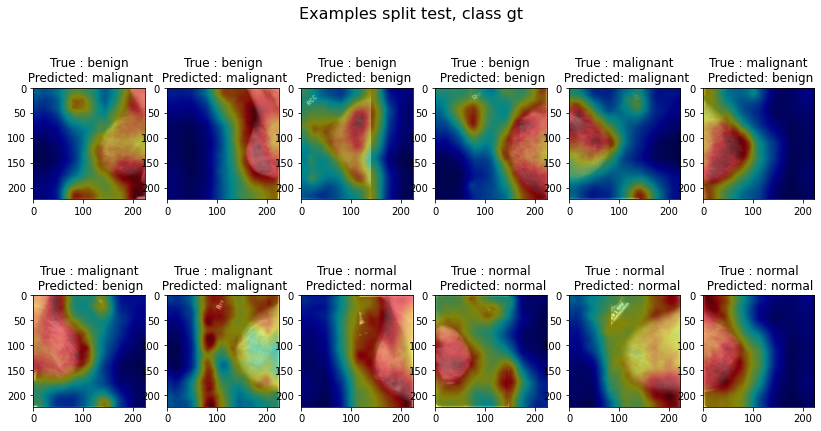

In [37]:
# Substitute GradCAM for one of the following, to test other methods:
# GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
# Also substitute class_id for pred, or a class id in [0,1,2] to check different output.
plot_cams(dataloaders, cam_method=FullGrad, class_id='gt')

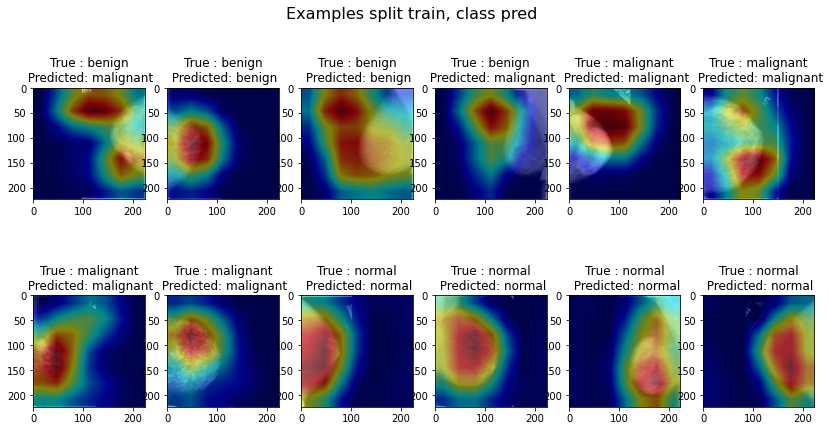

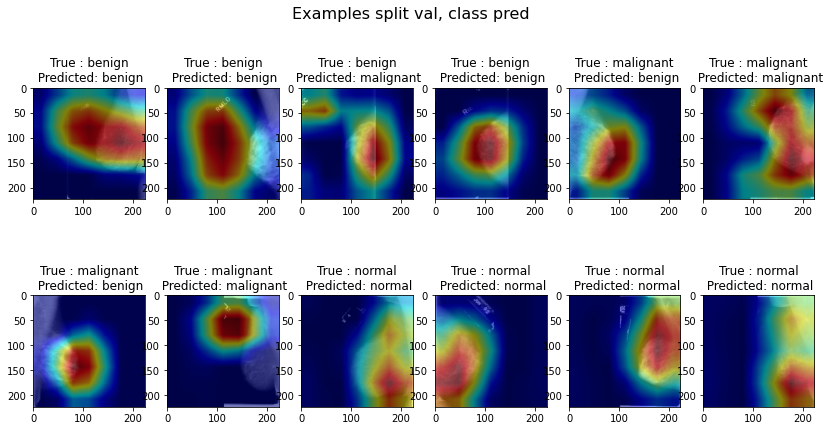

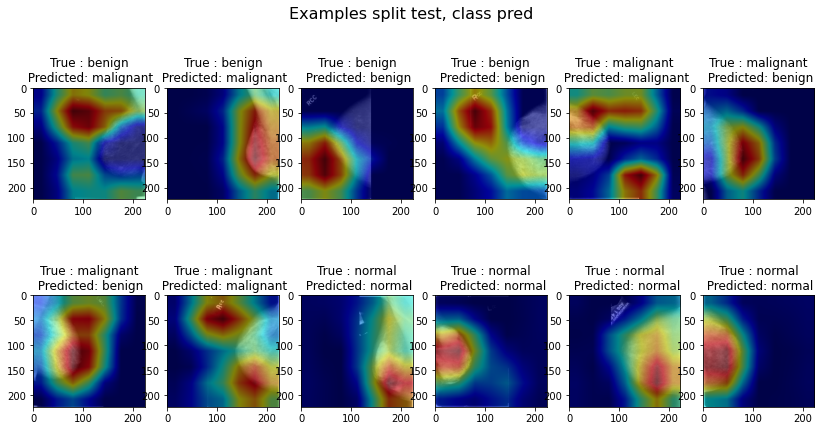

In [38]:
plot_cams(dataloaders, cam_method=GradCAM, class_id='pred')

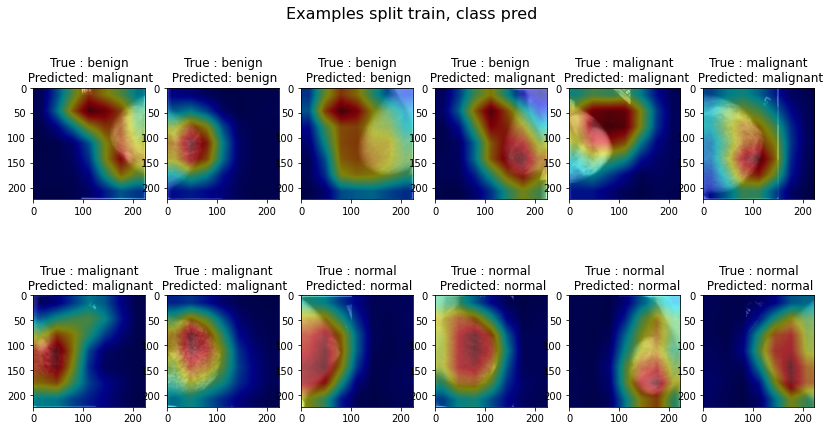

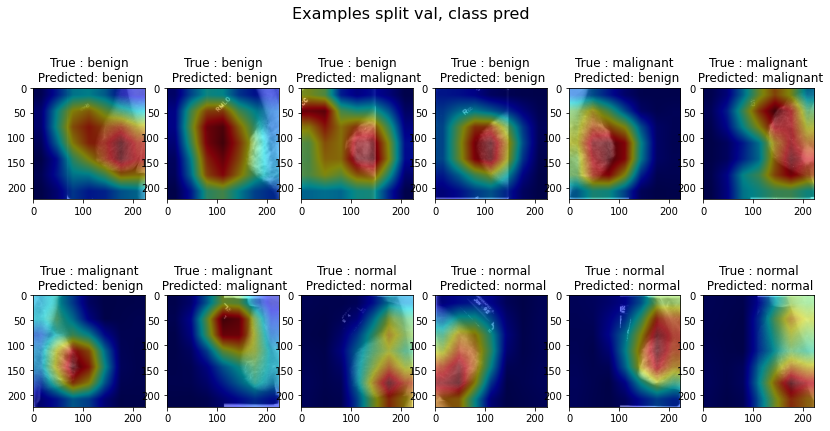

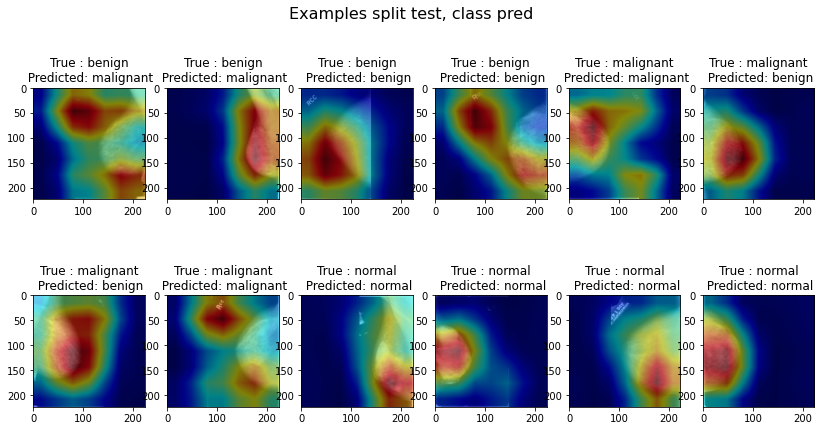

In [39]:
plot_cams(dataloaders, cam_method=GradCAMPlusPlus, class_id='pred')

# Q4) Evaluate on external dataset (2 points)


In this question we will study a problem that occurs frequently in practice when deploying systems. Oftentimes, the data distribution at test time is different than the one used in training.

To begin with, compare the performance with the original model against an external dataset of the same type, provided in data/external_dataset.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Top-1 Acc: 0.9477124183006537
External Top-1 Acc: 0.8790849673202614


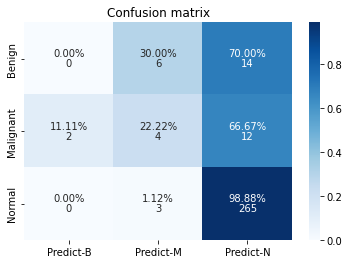

In [100]:
dataloaders_external = get_dataloaders(external_dataset_dir, input_size, batch_size, shuffle_datasets)

test_loss, test_top1, gt_labels, pred_labels = evaluate(model, dataloaders['test'], criterion, is_labelled = True, generate_labels = True, k = 1)
test_loss_ext, test_top1_ext, gt_labels_ext, pred_labels_ext = evaluate(model, dataloaders_external['test'], criterion, is_labelled = True, generate_labels = True, k = 1)

print("Top-1 Acc: {}".format(test_top1))
print("External Top-1 Acc: {}".format(test_top1_ext))
plot_confusion_matrix([[i] for i in gt_labels_ext], pred_labels_ext)

As you can see, performance is worse on the external dataset. Compare  samples of the two datsets visually, and report the differences that you appreciate.



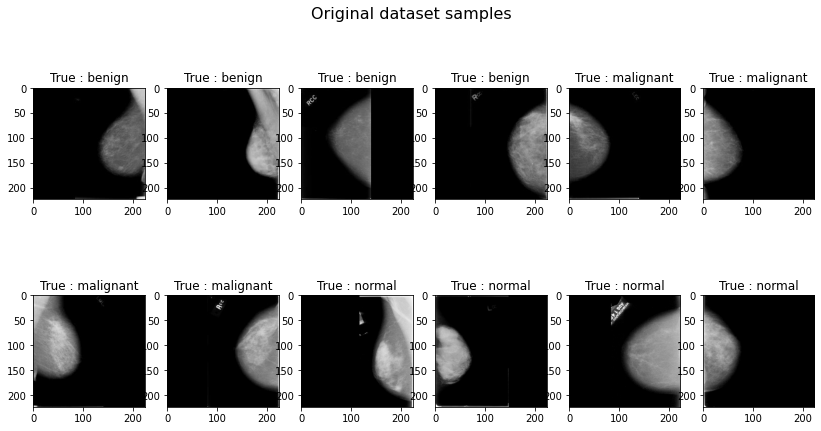

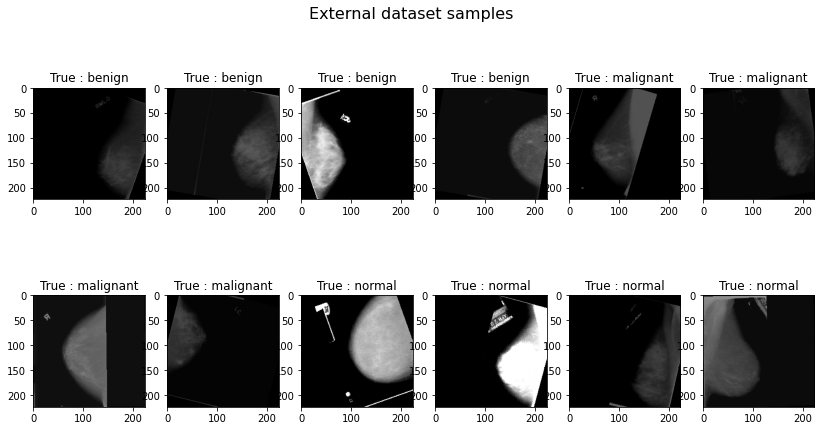

In [46]:
def plot_samples(dataloaders_external, title=''):
  fig, axs = plt.subplots(2, 6, figsize=(14, 7))
  fig.suptitle(title, fontsize=16)

  dataset = dataloaders_external['test'].dataset
  indices_per_class = defaultdict(list)
  for i, (_, c) in enumerate(dataset.imgs):
    indices_per_class[c].append(i)

  random.seed(1337)  
  indices = []
  for c in range(3):
    indices.extend(random.sample(indices_per_class[c], 4))

  for dataset_i, ax in zip(indices, axs.flatten()):
    img_file, class_idx = dataset.imgs[dataset_i]      
    img = np.array(PIL.Image.open(img_file))
    ax.set_title('True : %s' %(dataset.classes[class_idx]))
    if len(img.shape) == 2:
      img = np.tile(img[:,:,None], (1,1,3))
    ax.imshow(img)

# Plot some samples of each of the datasets:
plot_samples(dataloaders, 'Original dataset samples')
plot_samples(dataloaders_external, 'External dataset samples')

(6.869 only) Implement a set of transformations that can be applied to the original dataset at train time that would mitigate this issue. Plot the original dataset with the proposed transformations, which should produce qualitatively similar samples. You don't need to retrain the model, though you are free to do so to further check that the transformations are correct (performance on the external dataset should improve using the original data with the extra transformations). Use some of the transformations in: 

https://pytorch.org/vision/stable/transforms.html#transforms-on-pil-image-and-torch-tensor



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


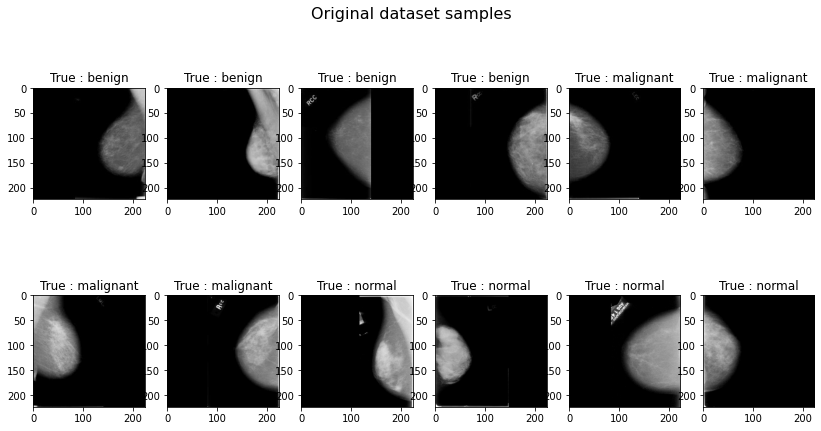

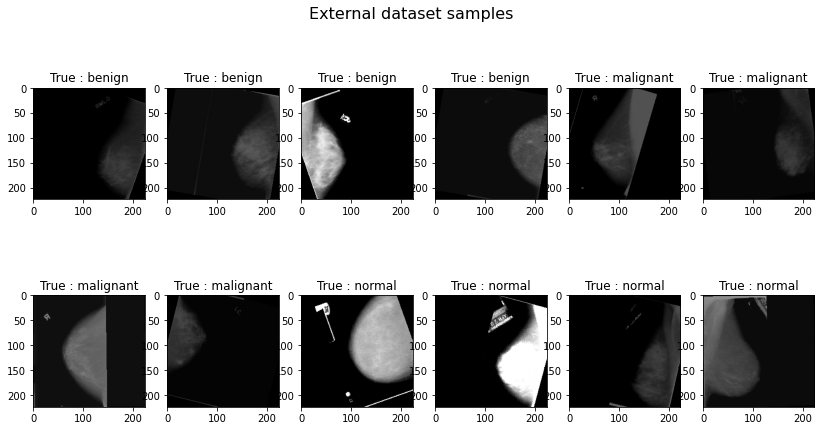

In [108]:
from torchvision.transforms.functional import to_grayscale
from torchvision.transforms import RandomRotation, ColorJitter
# TODO:
external_transforms = transforms.Compose([transforms.RandomRotation(degrees=(45,90)), transforms.RandomPerspective(distortion_scale=0.3, p=0.33, fill=0), 
                                          transforms.ColorJitter(brightness=.5), transforms.RandomAdjustSharpness(sharpness_factor=3), 
                                          transforms.RandomAffine(degrees=(10, 90), translate=(0.3, 0.5), scale=(0.25, 0.75)), transforms.RandomPosterize(bits=6)])

# END TODO
transform = transforms.Compose([external_transforms,get_image_transforms()])
modified_original_dataloaders = get_dataloaders(mias_dataset_dir, input_size, batch_size, shuffle_datasets, external_transforms)
plot_samples(modified_original_dataloaders, 'Original dataset samples')
plot_samples(dataloaders_external, 'External dataset samples')

# **Q5)** Class imbalance (2 points)

An issue typically present in medical datasets is class imbalance: patients that do not present the disease are more frequent than patients that do have the disease. One way to make the trained model perform differently is by simulating a dataset that contains a different number of samples of each category. This can be achieved by at least two methods: reweighting of the loss and changing the sampling procedure.

In [56]:
from collections import defaultdict 
# First we will compute statistics of the dataset:
dataloaders = get_dataloaders(mias_dataset_dir, input_size, batch_size, shuffle_datasets)
train_dataset = dataloaders['train'].dataset

samples_per_class = [0 for _ in range(3)]
for _, class_idx in train_dataset:
  samples_per_class[class_idx] += 1

print("Samples per class:")
for c_idx in range(3):
  print("Class {} ({}): {} samples".format(c_idx, train_dataset.classes[c_idx], samples_per_class[c_idx]))



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Samples per class:
Class 0 (benign): 186 samples
Class 1 (malignant): 132 samples
Class 2 (normal): 2146 samples


###**Q5 a)** Loss reweigthing

Complete the following lines below to reweight the loss so that the three classes are balanced. Then, excecute the training loop.

In [64]:
total_samples = sum(samples_per_class)

# TODO: add the weights per class so that the loss is balanced. 
# The sum of weights over all samples should sum up to total_samples (i.e. the same as if the weights where 1) 

weights_per_class = torch.tensor([186,132,2146], dtype=torch.float32)
weights_per_class = weights_per_class / weights_per_class.sum()
weights_per_class = 1.0 / weights_per_class
weights_per_class = (weights_per_class / weights_per_class.sum()).to(device)
# ENDTODO

reweighted_criterion = nn.CrossEntropyLoss(weight=weights_per_class)      

###**Q5 b)** Dataset rebalancing
Complete the following lines to modify the data loader so that samples for the three classes are balanced. For simplicity, you are allowed to select an element at random, and ignore the *item* argument of the dataset.__getitem__ function.
Then, excecute the training loop with the modified dataset/dataloader.

In [65]:
import random

from collections import defaultdict
class RebalancedDataset(datasets.ImageFolder):
  def __init__(self, class_probabilities, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.class_probabilities = class_probabilities
    self.items_per_class = defaultdict(list)
    
    for item_i, (_, c) in enumerate(self.imgs):
      self.items_per_class[c].append(item_i)

  def __getitem__(self, i_ignored):
    # ignores argument, and returns an element at random with reweighted class
    if i_ignored >= len(self):
      raise IndexError('Index is too large') # Exception required so that the iterator ends after len(self) samples
    # TODO: select a class at random following self.class_probabilities, and a random element for the class
    classes = [0,1,2]
    class_i = np.random.choice(classes, p = self.class_probabilities)
    i = np.random.choice(self.items_per_class[class_i])
    # ENDTODO
    return super().__getitem__(i)


In [66]:
# Replicates the original get_dataloaders, but in this case we substitute the training dataset for the RebalancedDataset
def get_dataloaders_rebalanced(class_probabilities, dataset_dir, input_size, batch_size, shuffle = True):
    data_transforms = {
        'train': get_image_transforms(),
        'val': get_image_transforms(),
        'test': get_image_transforms()
    }

    # Create training and validation datasets
    image_datasets = {'train': RebalancedDataset(class_probabilities, os.path.join(dataset_dir, 'train'), data_transforms['train']),
                      'val': datasets.ImageFolder(os.path.join(dataset_dir, 'val'), data_transforms['val']),
                      'test': datasets.ImageFolder(os.path.join(dataset_dir, 'test'), data_transforms['test'])}
    # Create training and validation dataloaders
    # Never shuffle the test set
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict

In [67]:
class_probabilities = [1/3 for _ in range(3)]
dataloaders_rebalanced = get_dataloaders_rebalanced(class_probabilities, mias_dataset_dir, input_size, batch_size, shuffle_datasets)

train_dataset_rebalanced = dataloaders_rebalanced['train'].dataset


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [68]:
from collections import defaultdict 

samples_per_class_rebalanced = [0 for _ in range(3)]
for _, class_idx in tqdm(train_dataset_rebalanced):
  samples_per_class_rebalanced[class_idx] += 1

print("Rebalanced samples per class:")
for c_idx in range(3):
  print("Class {} ({}): {} samples".format(c_idx, train_dataset_rebalanced.classes[c_idx], samples_per_class_rebalanced[c_idx]))



  0%|          | 0/2464 [00:00<?, ?it/s]

Rebalanced samples per class:
Class 0 (benign): 805 samples
Class 1 (malignant): 835 samples
Class 2 (normal): 824 samples


(6.869 only) Finally, train the models with the modified criterion and rebalanced dataloader

In [69]:
model_reweighted, input_size = initialize_model(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)

model_reweighted = model_reweighted.to(device)
optimizer_reweighted = make_optimizer(model_reweighted, learning_rate)
trained_reweighted, validation_history_reweighted, train_history_reweighted = train_model(model=model_reweighted, 
                                                                                          dataloaders=dataloaders, 
                                                                                          criterion=reweighted_criterion, 
                                                                                          optimizer=optimizer_reweighted,
                                                                                          save_dir=save_dir, 
                                                                                          save_all_epochs=save_all_epochs, 
                                                                                          num_epochs=num_epochs)

Epoch 1/3
----------


  0%|          | 0/77 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.0472 Acc: 0.5191


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss: 1.2409 Acc: 0.3762

Epoch 2/3
----------


  0%|          | 0/77 [00:00<?, ?it/s]

train Loss: 0.8313 Acc: 0.7074


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss: 2.6566 Acc: 0.0759

Epoch 3/3
----------


  0%|          | 0/77 [00:00<?, ?it/s]

train Loss: 0.6904 Acc: 0.7597


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss: 2.9203 Acc: 0.8812

Training complete in 0m 23s
Best val Acc: 0.881188


In [70]:
model_rebalanced, input_size = initialize_model(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)

model_rebalanced = model_rebalanced.to(device)
optimizer_rebalanced = make_optimizer(model_rebalanced, learning_rate)
trained_rebalanced, validation_history_rebalanced, train_history_rebalanced = train_model(model=model_rebalanced, 
                                                                                          dataloaders=dataloaders_rebalanced, 
                                                                                          criterion=criterion, 
                                                                                          optimizer=optimizer_rebalanced,
                                                                                          save_dir=save_dir, 
                                                                                          save_all_epochs=save_all_epochs, 
                                                                                          num_epochs=num_epochs)

Epoch 1/3
----------


  0%|          | 0/77 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6853 Acc: 0.6960


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss: 2.8564 Acc: 0.2310

Epoch 2/3
----------


  0%|          | 0/77 [00:00<?, ?it/s]

train Loss: 0.1984 Acc: 0.9343


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss: 4.2629 Acc: 0.1287

Epoch 3/3
----------


  0%|          | 0/77 [00:00<?, ?it/s]

train Loss: 0.0788 Acc: 0.9777


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss: 0.2365 Acc: 0.9274

Training complete in 0m 24s
Best val Acc: 0.927393


Finally, plot the confussion matrix for the three models, and explain empirical (if there are) and theoretical differences between the two techniques. 
Hint: think about the extreme case where the number of samples of the less predominant class is low.

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[[  9.  11.   0.]
 [  5.  13.   0.]
 [  0.   0. 268.]]


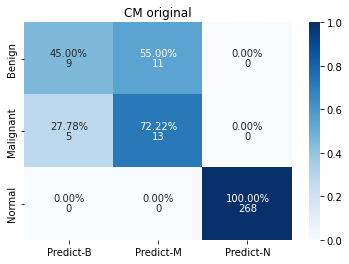

In [84]:
y_label_reweighted, y_pred_reweighted, _, _ =  get_eval_results(model, dataloaders)
plot_confusion_matrix(y_label_reweighted, y_pred_reweighted, title2='CM original')

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[[  0.   0.  20.]
 [  0.   0.  18.]
 [  0.   0. 268.]]


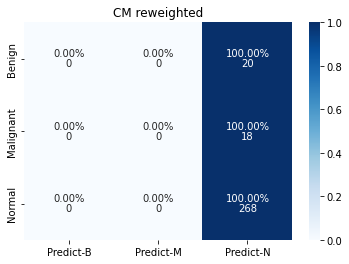

In [86]:
y_label_reweighted, y_pred_reweighted, _, _ =  get_eval_results(model_reweighted, dataloaders)
plot_confusion_matrix(y_label_reweighted, y_pred_reweighted, title2='CM reweighted')

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[[ 12.   6.   2.]
 [  9.   8.   1.]
 [  2.   2. 264.]]


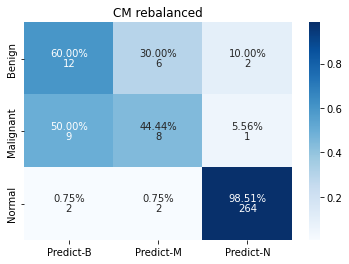

In [88]:
y_label_rebalanced, y_pred_rebalanced, _, _ =  get_eval_results(model_rebalanced, dataloaders)
plot_confusion_matrix(y_label_rebalanced, y_pred_rebalanced, title2='CM rebalanced')